In [ ]:
#The code should be run in a linear manner

In [1]:
import numpy as np
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# TextDataset is Described in Section 3.3 of Assignment 2

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V - 1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    # my_collate_function prepares batches

# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x, y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x, y in batch:
        #x padded
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [3]:
class CNNClassifier(torch.nn.Module):
    def __init__(self, word_vec,embedding_size,k1,n1,k2,n2):
        super().__init__()
        self.embed=torch.nn.Embedding.from_pretrained(word_vec,freeze=False)
        self.conv1=torch.nn.Conv2d(1, n1, (k1,embedding_size),bias=False)
        self.conv2=torch.nn.Conv2d(1, n2, (k2,embedding_size),bias=False)
        self.maxpool1=torch.nn.AdaptiveMaxPool1d(1)
        self.maxpool2=torch.nn.AdaptiveMaxPool1d(1)
        self.fc1 = torch.nn.Linear(n1+n2, 1)
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        torch.manual_seed(26)
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(0, 0.3)
            #print(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
    
    def forward(self, input):
        #B=batch size S=sentence length E=embedding size 
        #input=[S,B,E]
        squash=torch.nn.ReLU()
        binary=torch.nn.Sigmoid()
        pred= self.embed(input.swapaxes(0,1))#swap sentence length and batch size axis [B,S,E]
        pred=pred.unsqueeze(1)#[B,1,S,E]
        
        pred1= squash(self.conv1(pred))#[B,n1,S,1]
        pred1=torch.squeeze(pred1,3)#[B,n1,S]
        pred1=self.maxpool1(pred1)#[B,n1,1]
        
        pred2= squash(self.conv2(pred))#[B,n2,S,1]
        pred2=torch.squeeze(pred2,3)#[B,n2,S]
        pred2=self.maxpool2(pred2)#[B,n2,1]
        
        pred=torch.squeeze(torch.cat((pred1,pred2),1),2)#[B,n1+n2]
        pred= binary(self.fc1(pred))
        return pred

Using device: cuda
Memory allocated by device: 160647168
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Avg test loss= tensor(0.5515, device='cuda:0', grad_fn=<DivBackward0>) Test accu= tensor(0.9175, device='cuda:0')


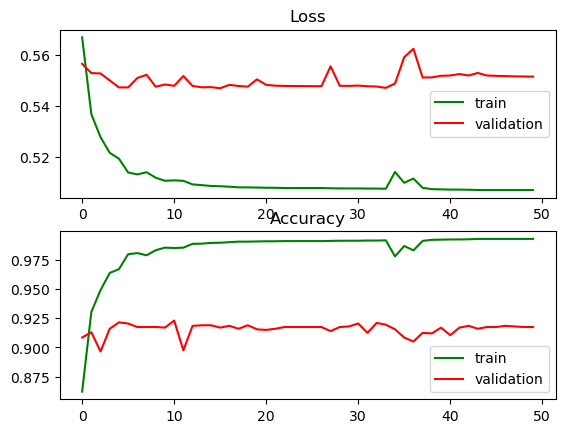

In [4]:
def decision(input,labels):
    return torch.sum((input>0.5)==labels)
def main(args):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    ### 3.3 Processing of the data ###
    # 3.3.1
    glove = torchtext.vocab.GloVe(name="6B", dim=100)  # embedding size = 100

    # 3.3.2
    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "test")
    test_dataset = TextDataset(glove, "test")

    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))


    net=CNNClassifier(glove.vectors.cuda(),100,3,230,4,230).cuda()
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=10e-4)
    num_epochs=50

    loss_train=np.zeros(num_epochs) 
    loss_val=np.zeros(num_epochs)
    accu_train=np.zeros(num_epochs)
    accu_val=np.zeros(num_epochs)
    print('Memory allocated by device:', torch.cuda.memory_allocated(device))
    for i in range(int(num_epochs)):
        train_iter=iter(train_dataloader) 
        val_iter=iter(validation_dataloader)
        #print(i)
        while True:
            try:    
                input, labels = next(train_iter)
                output = net(input.cuda())
                optimizer.zero_grad()  # zero the gradient buffers
                loss = criterion(output[:,0], labels.float())
                loss.backward()
                optimizer.step()
                loss_train[i]+=loss
                accu_train[i]+=decision(output[:,0],labels)
            except StopIteration:
                break
        while True:
            try:
                input, labels = next(val_iter)
                output = net(input.cuda())
                loss = criterion(output[:,0], labels.float())
                loss_val[i]+=loss
                accu_val[i]+=decision(output[:,0],labels)
            except StopIteration:
                break
                
    loss_train/=6400/args.batch_size #avg loss per sample
    loss_val/=2000/args.batch_size #avg loss per sample
    accu_train/=6400
    accu_val/=2000
    
    #plotting section
    fig, splot = plt.subplots(2)
    domain = np.arange(num_epochs)
    splot[0].plot(domain, loss_train, 'g',label="train")
    splot[0].plot(domain, loss_val, 'r',label="validation")
    splot[0].legend()
    splot[0].title.set_text("Loss")
    splot[1].plot(domain, accu_train, 'g',label="train")
    splot[1].plot(domain, accu_val, 'r',label="validation")
    splot[1].legend()
    splot[1].title.set_text("Accuracy")

    test_iter=iter(test_dataloader)
    loss=0
    accu=0
    while True:
        try:
            input, labels = next(test_iter)
            output = net(input.cuda())
            loss += criterion(output[:,0], labels.float())
            accu+=decision(output[:,0],labels)
        except StopIteration:
            break
    loss/=2000/args.batch_size
    accu=accu/torch.tensor(2000)
    print("Avg test loss=",loss,"Test accu=",accu)
      
    return net
    
class Args:
    def __init__(self, bs):
        self.batch_size = bs
        
net=main(Args(32))      

In [11]:
state_dict = net.state_dict()
subject3 = state_dict['conv1.weight'][0:5][:][:][:].cpu()
subject4 = state_dict['conv2.weight'][0:5][:][:][:].cpu()
mapping=state_dict['embed.weight'].cpu()
print(subject3.size())
print(subject4.size())
print(mapping.size())

glove = torchtext.vocab.GloVe(name="6B", dim=100)  # embedding size = 100


def print_closest_cosine_words(vec, n=5):
    dists = torch.cosine_similarity(mapping, vec, dim=1)
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1], reverse=True)  # sort by distance
    for idx, difference in lst[0:n]:  # take the top n
        print(glove.itos[idx], "\t%5.3f" % difference)
    print("\n")


for j in range(5):
    print("the", j, "th kernel is")
    for i in range(3):
        word = torch.squeeze(subject3[j, :, i, :])
        print_closest_cosine_words(word)
for j in range(5):
    print("the", j, "th kernel is")
    for i in range(4):
        word = torch.squeeze(subject4[j, :, i, :])
        print_closest_cosine_words(word)

torch.Size([5, 1, 3, 100])
torch.Size([5, 1, 4, 100])
torch.Size([400000, 100])
the 0 th kernel is
brooked 	0.585
suscriptos 	0.507
theres 	0.472
nary 	0.464
teetotaler 	0.445

three-player 	0.462
meatless 	0.439
deceptively 	0.435
gorgeously 	0.424
semi-infinite 	0.422

militate 	0.520
snoozer 	0.517
lensing 	0.495
overpraised 	0.493
bureaucratese 	0.483


the 1 th kernel is
3-tier 	0.558
200-man 	0.557
10-cd 	0.553
four-gun 	0.552
1.5-ounce 	0.552

narrator 	0.442
satire 	0.430
uninvolving 	0.420
counterintuitively 	0.410
autobiographical 	0.409

mediocrity 	0.433
advisedly 	0.418
serviceable 	0.418
nonfunctional 	0.417
plax 	0.415


the 2 th kernel is
misiano 	0.428
cimirotic 	0.419
f.r.s. 	0.419
maksimović 	0.419
knoch 	0.409

9.687 	0.571
9.575 	0.562
fetishistic 	0.534
80-point 	0.527
tweezer 	0.525

http://yang.sprl.umich.edu 	0.403
overdubs 	0.379
first-team 	0.378
coxnews@nytimes.com 	0.378
exam 	0.373


the 3 th kernel is
kooch 	0.556
pahk 	0.554
flah 	0.550
ghah 	0.548
nah 	

In [10]:
torch.save(net.state_dict(), 'cnn.pt')